In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

count = 0
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        count += 1
        
print(f"There are total {count} number of images.")
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

There are total 13972 number of images.


#### Importing All the Necessary Packages

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import cv2
from sklearn.model_selection import train_test_split 
import warnings; warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.1.2


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Available computing device: {device}")

Available computing device: cuda


In [4]:
!nvidia-smi

Fri Aug 16 13:31:29 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P0             27W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Yeah we have access to GPU.

#### Let's get to know about the data

Let's write a small helper function to ber able to walk through each subdirectories in our data storage structure and count the total number of files that we have for our problem.

In [5]:
import os
from pathlib import Path

def walk_through_directory(dir_path: Path):
    """
    Walks through the content of the directory and returning it.
    Args:
        dir_path (str or pathlib.Path): target_directory
        
    Return:
        A print out of:
          number of subdiretories in dir_path
          number of images (files) in each subdirectory
          name of each subdirectory
    """
    
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
data_path = Path("/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset")
image_path = data_path / "Images"

walk_through_directory(image_path)

There are 58 directories and 0 images in '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images'.
There are 0 directories and 201 images in '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/7'.
There are 0 directories and 144 images in '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/47'.
There are 0 directories and 201 images in '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/17'.
There are 0 directories and 201 images in '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/19'.
There are 0 directories and 201 images in '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/22'.
There are 0 directories and 201 images in '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/2'.
There are 0 directories and 201 images in '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/35'.
There are 0 directories and 193 images in '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/50'.
There are 0 dire

Here We have to split our data into train, test and validation by ourself because we don't have it by default.

**Approach 1:** loading all images as a full dataset and then make use of random_split to get the desired splited data.

In [7]:
class OpenCVTransformation:
    def __init__(self):
        pass
    
    def __call__(self, img):
        
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
        img = cv2.equalizeHist(img)
        
        return img

In [7]:
def get_image_paths_and_labels(root_dir):
    image_paths = []
    labels = []

    for class_name in sorted(os.listdir(root_dir)):
        class_dir = os.path.join(root_dir, class_name)
        if os.path.isdir(class_dir):
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                image_paths.append(Path(image_path))
                labels.append(class_name)
                
    return image_paths, labels

In [8]:
paths_of_images, labels = get_image_paths_and_labels(image_path)

In [9]:
def split_data(image_path_list, label_list, splitting_ratio = 0.2):
    
    image_path_, test_image_path_list, label_, test_label_list = train_test_split(
        image_path_list, label_list, test_size = splitting_ratio,
        stratify = label_list, random_state = 32
    )
    
    train_image_path_list, validation_image_path_list, train_label_list, validation_label_list = train_test_split(
        image_path_, label_, test_size = splitting_ratio - 0.1,
        stratify = label_, random_state = 32)
    
    return train_image_path_list, test_image_path_list, validation_image_path_list, train_label_list, test_label_list, validation_label_list

In [10]:
train_image_path_list, test_image_path_list, validation_image_path_list, train_label_list, test_label_list, validation_label_list = split_data(
    image_path_list = paths_of_images,
    label_list = labels
)

print(f"Number of train images and labels: {len(train_image_path_list), len(train_label_list)}")
print(f"Number of test images and labels: {len(test_image_path_list), len(test_label_list)}")
print(f"Number of validation images and labels: {len(validation_image_path_list), len(validation_label_list)}")

Number of train images and labels: (10058, 10058)
Number of test images and labels: (2795, 2795)
Number of validation images and labels: (1118, 1118)


In [7]:
## loading the label data to get the corresponding sign name which we'll use furthur
data = pd.read_csv("/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/traffic_sign.csv")
data.head()

,ClassId,Name
0,0,Give way
1,1,No entry
2,2,One-way traffic
3,3,One-way traffic
4,4,No vehicles in both directions


Let's display some of the sample images.

In [13]:
from typing import List

In [14]:
def plot_random_images(image_paths: List[Path], labels: List[str]):
    
    cols = 5
    no_of_classes = len(list(os.listdir(image_path))) + 1

    fig, ax = plt.subplots(nrows = no_of_classes, ncols = cols, figsize = (5, 300))
    fig.tight_layout()

    for j, row in data.iterrows():
        count = 0
        for x in labels:
            if int(x) == j:
                if count != 5:
                    idx = labels.index(x)
                    img = cv2.imread(image_paths[idx])
                    ax[j][count].imshow(img, cmap="gray")
                    ax[j][count].axis('off')
                    if count == 2:
                        ax[j][count].set_title(str(j)+" "+row["Name"])
                    count += 1
                else:
                    break

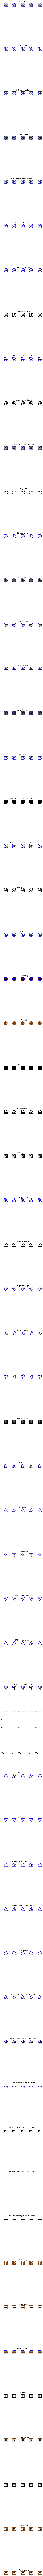

In [212]:
plot_random_images(image_paths = train_image_path_list, labels = train_label_list)

Let's create a custom Dataset class to get the separate Dataset objects.

As we know that a Dataset object have two attributes classes and class_to_idx to get the class names and indices for the respective class.

Let's implement that functionality for our custom Dataset class.

In [15]:
from typing import Tuple, List, Dict
def find_classes(dir_path: str) -> Tuple[List[str], Dict[str, int]]:
    """Finds the class names for the images in the targeted directory.
    
    Assumes that the images are in the standard image classification format.
    
    Args:
        dir_path (str): target directory to load class names from
        
    Returns:
        Tuple[List[str], Dict[str, int]]: (list_of_class_names, dict(class_name : inx))
    """
    
    classes = sorted(entry.name for entry in os.scandir(dir_path) if entry.is_dir())
    
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {dir_path}")
        
    class_to_idx = {class_name : i for i, class_name in enumerate(classes)} 
    
    return classes, class_to_idx

In [16]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, root_dir: str, image_paths: List[Path], transform: None) -> None:
        self.paths = image_paths
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(dir_path = root_dir)
        
    def __len__(self) -> int:
        return len(self.paths)
    
    def load_image(self, idx) -> Image.Image:
        path = self.paths[idx]
        img = cv2.imread(path)
        return img
        
    def __getitem__(self, idx) -> Tuple[torch.Tensor, int]:
        img = self.load_image(idx)
        class_name = self.paths[idx].parent.name
        
        if self.transform:
            img = self.transform(img)
            
        return img, int(class_name)

In [19]:
train_data_transformation = transforms.Compose([
    OpenCVTransformation(),
    transforms.ToPILImage(),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor(),
])

test_data_transformation = transforms.Compose([
    OpenCVTransformation(),
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

Checking whether the data transformation logic works properly or not.

In [17]:
import random
## Writing a function to apply the custom transform to set of images
def plot_transformed_images(image_paths, transform, n=4):
    """
    Plots the random set of images from the image_path.
    Will take the n images from image_paths and apply transformation.
    Also plot them side by side with their transformed version.
    
    Args:
        image_paths: List of images
        transform: transformation to be apply to images
        n: number of images to plot
    """
    
    random_images_path = random.sample(image_paths, k=n)
    
    for image_path in random_images_path:
        
        img = cv2.imread(image_path)
        
        fig, ax = plt.subplots(1, 2)
            
        ax[0].imshow(img, cmap="gray")
        ax[0].set_title(f"original image\nsize: {img.shape}")
        ax[0].axis("off")
        
        transformed_image = transform(img)
            
        ax[1].imshow(transformed_image.permute(1, 2, 0), cmap="gray")
        ax[1].set_title(f"transformed image\nsize: {transformed_image.shape}")
        ax[1].axis("off")
            
        fig.suptitle(f"Class name: {image_path.parent.stem}")

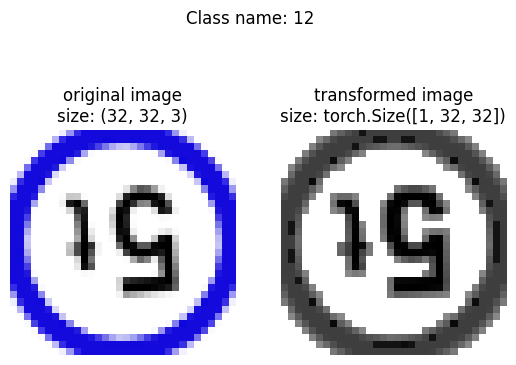

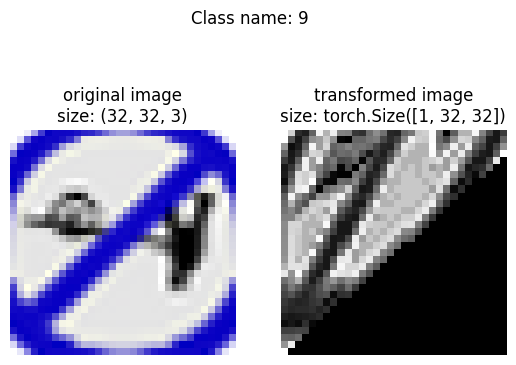

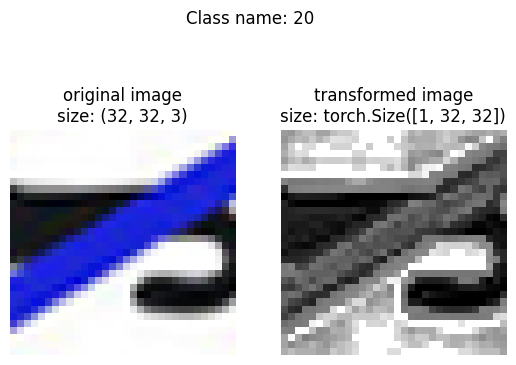

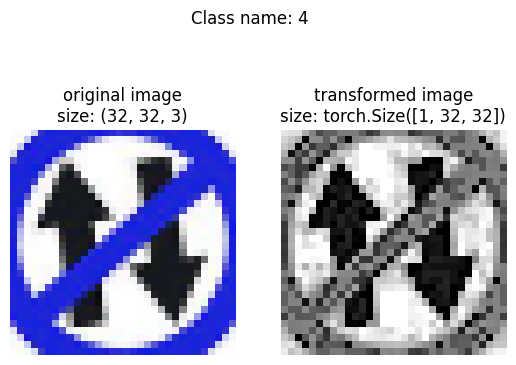

In [21]:
plot_transformed_images(image_paths = train_image_path_list, transform = train_data_transformation)

Yeah! It works as expected.

In [22]:
train_dataset = CustomDataset(root_dir = image_path, image_paths = train_image_path_list, transform = train_data_transformation)
validation_dataset = CustomDataset(root_dir = image_path, image_paths = validation_image_path_list, transform = test_data_transformation)
test_dataset = CustomDataset(root_dir = image_path, image_paths = test_image_path_list, transform = test_data_transformation)

print(f"Number of train images examples: {len(train_dataset)}")
print(f"Number of test images examples: {len(test_dataset)}")
print(f"Number of validation examples: {len(validation_dataset)}")

Number of train images examples: 8940
Number of test images examples: 2795
Number of validation examples: 2236


Another great way to become one with data is to see the shape of the data.

Image Tensor:
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.3255, 0.3255, 0.9647,  ..., 1.0000, 0.3255, 0.3255],
         [0.3255, 0.3255, 0.3255,  ..., 0.3255, 0.3255, 0.3255],
         [1.0000, 0.3255, 0.3255,  ..., 0.3255, 0.3255, 1.0000]]])
Shape of image: torch.Size([1, 32, 32])
Datatype of image: torch.float32
Label: 34
Label datatype: <class 'int'>


(-0.5, 31.5, 31.5, -0.5)

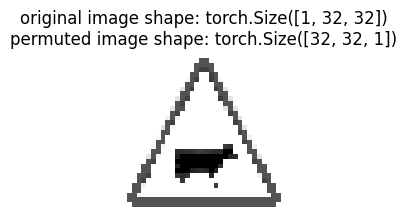

In [23]:
image, label = train_dataset[50]

print(f"Image Tensor:\n{image}")
print(f"Shape of image: {image.shape}")
print(f"Datatype of image: {image.dtype}")
print(f"Label: {label}")
print(f"Label datatype: {type(label)}")

img = image.permute(1, 2, 0)

plt.figure(figsize=(4, 2))
plt.imshow(img, cmap='gray')
plt.title(f"original image shape: {image.shape}\npermuted image shape: {img.shape}")
plt.axis(False)

Let's analyze the distribution of all classes among the different splits of data that we have

In [18]:
from collections import Counter

def analyze_class_dist(data, name):
    
    counts_of_label = Counter()
    total_samples = len(data)
    
    for _, label in data:
        counts_of_label[label] += 1
        
    print(f"\n{name} set class distribution:")
    print(f"Total samples: {total_samples}")
    
    for label, count in counts_of_label.items():
        percentage = (count / total_samples) * 100
        print(f"Class: {label} | Count: {count} samples ({percentage:.2f}%)")

In [26]:
analyze_class_dist(train_dataset, "Train")


Train set class distribution:
Total samples: 8940
Class: 35 | Count: 129 samples (1.44%)
Class: 5 | Count: 204 samples (2.28%)
Class: 54 | Count: 384 samples (4.30%)
Class: 52 | Count: 140 samples (1.57%)
Class: 30 | Count: 128 samples (1.43%)
Class: 8 | Count: 384 samples (4.30%)
Class: 29 | Count: 128 samples (1.43%)
Class: 12 | Count: 129 samples (1.44%)
Class: 51 | Count: 384 samples (4.30%)
Class: 20 | Count: 384 samples (4.30%)
Class: 3 | Count: 129 samples (1.44%)
Class: 10 | Count: 129 samples (1.44%)
Class: 2 | Count: 129 samples (1.44%)
Class: 50 | Count: 123 samples (1.38%)
Class: 46 | Count: 129 samples (1.44%)
Class: 45 | Count: 129 samples (1.44%)
Class: 55 | Count: 393 samples (4.40%)
Class: 32 | Count: 129 samples (1.44%)
Class: 56 | Count: 128 samples (1.43%)
Class: 24 | Count: 129 samples (1.44%)
Class: 16 | Count: 128 samples (1.43%)
Class: 1 | Count: 129 samples (1.44%)
Class: 25 | Count: 129 samples (1.44%)
Class: 9 | Count: 129 samples (1.44%)
Class: 40 | Count: 

In [27]:
analyze_class_dist(test_dataset, "Test")


Test set class distribution:
Total samples: 2795
Class: 28 | Count: 40 samples (1.43%)
Class: 40 | Count: 40 samples (1.43%)
Class: 37 | Count: 40 samples (1.43%)
Class: 6 | Count: 40 samples (1.43%)
Class: 20 | Count: 121 samples (4.33%)
Class: 15 | Count: 40 samples (1.43%)
Class: 34 | Count: 40 samples (1.43%)
Class: 26 | Count: 40 samples (1.43%)
Class: 35 | Count: 40 samples (1.43%)
Class: 48 | Count: 34 samples (1.22%)
Class: 50 | Count: 39 samples (1.40%)
Class: 55 | Count: 124 samples (4.44%)
Class: 45 | Count: 40 samples (1.43%)
Class: 5 | Count: 65 samples (2.33%)
Class: 31 | Count: 41 samples (1.47%)
Class: 12 | Count: 40 samples (1.43%)
Class: 43 | Count: 40 samples (1.43%)
Class: 54 | Count: 121 samples (4.33%)
Class: 24 | Count: 40 samples (1.43%)
Class: 11 | Count: 40 samples (1.43%)
Class: 29 | Count: 40 samples (1.43%)
Class: 8 | Count: 121 samples (4.33%)
Class: 9 | Count: 40 samples (1.43%)
Class: 17 | Count: 40 samples (1.43%)
Class: 1 | Count: 40 samples (1.43%)
C

In [28]:
analyze_class_dist(validation_dataset, "Validation")


Validation set class distribution:
Total samples: 2236
Class: 7 | Count: 32 samples (1.43%)
Class: 26 | Count: 32 samples (1.43%)
Class: 13 | Count: 32 samples (1.43%)
Class: 4 | Count: 32 samples (1.43%)
Class: 9 | Count: 32 samples (1.43%)
Class: 2 | Count: 32 samples (1.43%)
Class: 43 | Count: 32 samples (1.43%)
Class: 57 | Count: 32 samples (1.43%)
Class: 38 | Count: 32 samples (1.43%)
Class: 56 | Count: 32 samples (1.43%)
Class: 16 | Count: 33 samples (1.48%)
Class: 20 | Count: 96 samples (4.29%)
Class: 24 | Count: 32 samples (1.43%)
Class: 54 | Count: 97 samples (4.34%)
Class: 15 | Count: 32 samples (1.43%)
Class: 40 | Count: 32 samples (1.43%)
Class: 53 | Count: 97 samples (4.34%)
Class: 51 | Count: 96 samples (4.29%)
Class: 47 | Count: 23 samples (1.03%)
Class: 18 | Count: 33 samples (1.48%)
Class: 41 | Count: 32 samples (1.43%)
Class: 31 | Count: 32 samples (1.43%)
Class: 6 | Count: 32 samples (1.43%)
Class: 33 | Count: 32 samples (1.43%)
Class: 14 | Count: 32 samples (1.43%)

Woah! We have fairly equal distribution of all the classes for each train, test and validation dataset.

In [30]:
## Converting train, validation and test datasets into dataloader objects
train_dataloader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    num_workers = os.cpu_count(),
    shuffle = True
)

validation_dataloader = DataLoader(
    dataset = validation_dataset,
    batch_size = 32,
    num_workers = os.cpu_count(),
    shuffle = False
)

test_dataloader = DataLoader(
    dataset = test_dataset,
    batch_size = 32,
    num_workers = os.cpu_count(),
    shuffle = False
)

train_dataloader, validation_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x79fa880c5ed0>,
 <torch.utils.data.dataloader.DataLoader at 0x79fa880c4cd0>)

In [31]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channel, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 1, 32, 32]) -> [batch_size, color_channel, height, width]
Label shape: torch.Size([32])


In [19]:
## Let's check it by displaying certain images
from typing import List

def display_random_images(
    dataset: torch.utils.data.Dataset,
    classes: List[str],
    n: int = 5,
    display_shape: bool = True
):
    if n > 5:
        n = 5
        display_shape = False
        print(f"If you want to display the images then n should be less then or equal to {n}. converting it to n and removing the shape display.")
        
    random_images_index = random.sample(range(len(dataset)), k=n)
    
    plt.figure(figsize=(16, 8))
    
    for i, target_sample in enumerate(random_images_index):
        target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]

        target_image = target_image.permute(1, 2, 0)
        
        plt.subplot(1, n, i+1)
        plt.imshow(target_image, cmap="gray")
        plt.axis("off")
        if classes:
            title = f"{classes[target_label]}"
            if display_shape:
                title = title + f"\nshape: {target_image.shape}"
        plt.title(title)

If you want to display the images then n should be less then or equal to 5. converting it to n and removing the shape display.


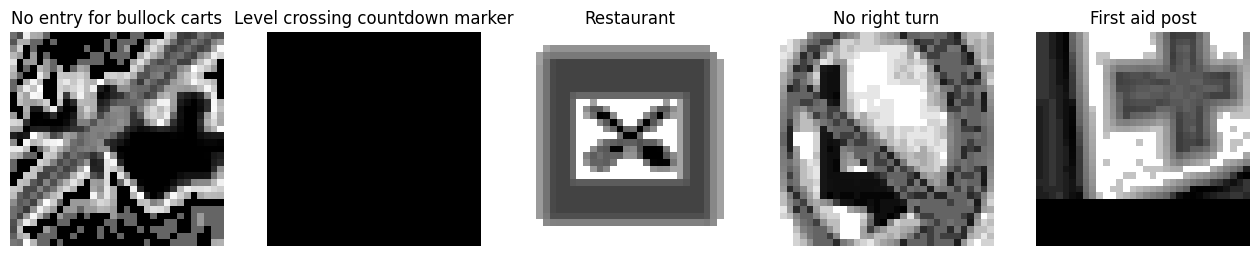

In [36]:
class_names = list(data["Name"])

display_random_images(
    dataset=train_dataset,
    classes=class_names,
    n=10
)

Woah! Now we have got our DataLoader object ready. It's time to train a CNN.

#### Creating Model Class

In [37]:
class TrafficModelv0(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units, out_channels = int(hidden_units / 2), kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = int(hidden_units / 2), out_channels = int(hidden_units / 2), kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = int(hidden_units / 2), out_channels = int(hidden_units / 4), kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = int(hidden_units / 4)*8*8,
                      out_features = output_shape)
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [38]:
traffic_model_v0 = TrafficModelv0(
    input_shape=1,
    hidden_units=64,
    output_shape=len(class_names)
).to(device)

traffic_model_v0

TrafficModelv0(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=59, bias=True)
  )
)

Let's try to make prediction on single image to see the working of forward pass.

In [39]:
try:
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo
    
from torchinfo import summary

summary(traffic_model_v0, input_size=[1, 1, 32, 32])

Layer (type:depth-idx)                   Output Shape              Param #
TrafficModelv0                           [1, 59]                   --
├─Sequential: 1-1                        [1, 32, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           640
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 32, 32, 32]           18,464
│    └─ReLU: 2-4                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-5                    [1, 32, 16, 16]           --
├─Sequential: 1-2                        [1, 16, 8, 8]             --
│    └─Conv2d: 2-6                       [1, 32, 16, 16]           9,248
│    └─ReLU: 2-7                         [1, 32, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 16, 16, 16]           4,624
│    └─ReLU: 2-9                         [1, 16, 16, 16]           --
│    └─MaxPool2d: 2-10                   [1, 16, 8, 8]             --
├─Se

In [191]:
img_batch, label_batch = next(iter(train_dataloader))

image, label = img_batch[0].unsqueeze(dim = 0), label_batch[0]

print(f"Image shape: {image.shape}")

traffic_model_v0.eval()
with torch.inference_mode():
    pred = traffic_model_v0(image.to(device))
    
print(f"Prediction Logits: \n{pred}")
print(f"\nPrediction Probabilities: \n{torch.softmax(pred, dim = 1)}")
print(f"\nPrediction Label: {torch.argmax(torch.softmax(pred, dim = 1), dim = 1).squeeze()}")
print(f"\nActual Label: {label}")

Image shape: torch.Size([1, 1, 32, 32])
Prediction Logits: 
tensor([[-4.2132e-02,  1.3672e-02, -8.7725e-03, -7.0721e-03,  2.4774e-03,
         -2.6947e-02,  9.4998e-05, -2.0111e-03,  3.8530e-02,  3.8071e-03,
         -2.1891e-02,  1.5757e-02, -1.6172e-02, -1.7349e-02, -1.5630e-02,
         -3.2413e-02,  4.6655e-03,  1.9386e-03, -1.3807e-02,  6.2580e-04,
          1.4178e-02,  2.4854e-02,  9.9416e-03, -7.3394e-03, -2.1171e-03,
         -1.4851e-02,  5.9572e-02,  2.4499e-02, -5.1809e-03, -2.5394e-02,
         -3.7192e-02, -3.7783e-02, -6.9364e-03, -1.6639e-02,  2.5352e-02,
          1.8881e-02, -1.6895e-02,  1.7750e-02, -2.1329e-02,  3.0034e-02,
         -3.5074e-02,  2.5549e-02, -3.0817e-02,  3.1793e-02, -2.4004e-02,
          2.2512e-02,  6.4536e-03, -3.6844e-02,  4.7632e-02, -2.2401e-02,
         -4.4935e-02, -1.2356e-02, -5.4061e-02,  6.5159e-03, -6.1746e-02,
         -2.9195e-02, -1.1310e-02, -1.7136e-02,  9.0915e-03]], device='cuda:0')

Prediction Probabilities: 
tensor([[0.0163, 0

In [192]:
image_batch, label_batch = next(iter(train_dataloader))

traffic_model_v0.eval()
with torch.inference_mode():
    
    image_batch, label_batch = image_batch.to(device), label_batch.to(device)
    
    y_logits = traffic_model_v0(image_batch)
    y_pred = torch.argmax(torch.softmax(y_logits, dim = 1), dim = 1)
    
print(f"Prediction Logits: \n{y_logits}\nShape: {y_logits.shape}\nDatatype: {y_logits.dtype}")
print(f"\nPrediction Class: \n{y_pred}\nShape: {y_pred.shape}\nDatatype: {y_pred.dtype}")
print(f"\nActual Class: \n{label_batch}\nShape: {label_batch.shape}\nDatatype: {label_batch.dtype}")

Prediction Logits: 
tensor([[-0.0407,  0.0206,  0.0007,  ..., -0.0148, -0.0143,  0.0105],
        [-0.0385,  0.0219, -0.0032,  ..., -0.0129, -0.0128,  0.0073],
        [-0.0379,  0.0193, -0.0047,  ..., -0.0139, -0.0156,  0.0055],
        ...,
        [-0.0377,  0.0155, -0.0017,  ..., -0.0143, -0.0124,  0.0178],
        [-0.0345,  0.0115, -0.0011,  ..., -0.0057, -0.0131,  0.0131],
        [-0.0447,  0.0249,  0.0033,  ..., -0.0183, -0.0185,  0.0125]],
       device='cuda:0')
Shape: torch.Size([32, 59])
Datatype: torch.float32

Prediction Class: 
tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26],
       device='cuda:0')
Shape: torch.Size([32])
Datatype: torch.int64

Actual Class: 
tensor([51, 10, 54,  2, 25, 25, 52, 19,  8, 12, 54, 32, 20, 20,  8, 27, 23, 35,
         9, 27, 35, 10, 16, 20, 56,  0,  5, 56, 58, 15, 20, 19],
       device='cuda:0')
Shape: torch.Size([32])
Datatype: torch.int64


#### Defining training and testing steps to train the model

In [20]:
def train_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fun: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fun,
):
    
    model.train()
    
    train_loss, train_accuracy = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        
        X, y = X.to(device), y.to(device)
        
        y_logits = model(X)
        y_pred = torch.argmax(torch.softmax(y_logits, dim = 1), dim = 1)
        
        loss = loss_fun(y_logits, y)
        train_loss += loss.item()
        
        train_accuracy += accuracy_fun(y_true=y, y_pred=y_pred)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
    train_loss = train_loss / len(dataloader)
    train_accuracy = train_accuracy / len(dataloader)
    
    return train_loss, train_accuracy

In [21]:
def test_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fun: nn.Module,
    accuracy_fun,
):
    
    model.eval()
    
    validation_loss, validation_accuracy = 0, 0
    
    with torch.inference_mode():
        
        for batch, (X, y) in enumerate(dataloader):
            
            X, y = X.to(device), y.to(device)
            
            y_logits = model(X)
            y_pred = torch.argmax(torch.softmax(y_logits, dim = 1), dim = 1)
            
            loss = loss_fun(y_logits, y)
            validation_loss += loss.item()
            validation_accuracy += accuracy_fun(y_true=y, y_pred=y_pred)
            
    validation_loss = validation_loss / len(dataloader)
    validation_accuracy = validation_accuracy / len(dataloader)
        
    return validation_loss, validation_accuracy

In [22]:
from tqdm.auto import tqdm
from typing import Dict, List

def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    validation_dataloader: torch.utils.data.DataLoader,
    loss_fun: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fun,
    epochs: int = 10
) -> Dict[str, List]:
    
    results = {
        "train_loss" : [],
        "train_accuracy" : [],
        "validation_loss" : [],
        "validation_accuracy" : []
    }
    
    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(
            model = model,
            dataloader = train_dataloader,
            loss_fun = loss_fun,
            optimizer = optimizer,
            accuracy_fun = accuracy_fun
        )
        
        validation_loss, validation_accuracy = test_step(
            model = model,
            dataloader = validation_dataloader,
            loss_fun = loss_fun,
            accuracy_fun = accuracy_fun
        )
        
        print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} Train Accuracy {train_accuracy:.4f} | Validation Loss {validation_loss:.4f} Validation Accuracy {validation_accuracy:.4f}")
        
        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["validation_loss"].append(validation_loss)
        results["validation_accuracy"].append(validation_accuracy)
    
    return results

In [23]:
def plot_loss_curves(a: Dict[str, List]):
    """
    Plotting the curve of loss and accuracy for the training process.
    
    Args:
        a (Dict[str, List]): result dictionary containing values
    """
    
    train_loss = a["train_loss"]
    test_loss = a["validation_loss"]
    
    train_accuracy = a["train_accuracy"]
    test_accuracy = a["validation_accuracy"]
    
    epochs = range(len(a["train_loss"]))
    
    plt.figure(figsize = (16, 8))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label = "train_loss")
    plt.plot(epochs, test_loss, label = "validation_loss")
    plt.title("Loss Curves of the Training Process")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracy, label = "train_accuracy")
    plt.plot(epochs, test_accuracy, label = "validation_accuracy")
    plt.title("Accuracy Curves of the Training Process")
    plt.xlabel("Epochs")
    plt.legend()

In [40]:
loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(traffic_model_v0.parameters(), lr=0.001)

In [24]:
def accuracy_fun(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    accuracy_score = (correct / len(y_pred)) * 100
    return accuracy_score

In [26]:
EPOCHS = 200

from timeit import default_timer as timer

start_time = timer()

model_v0_results = train(
    model = traffic_model_v0,
    train_dataloader = train_dataloader,
    validation_dataloader = validation_dataloader,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

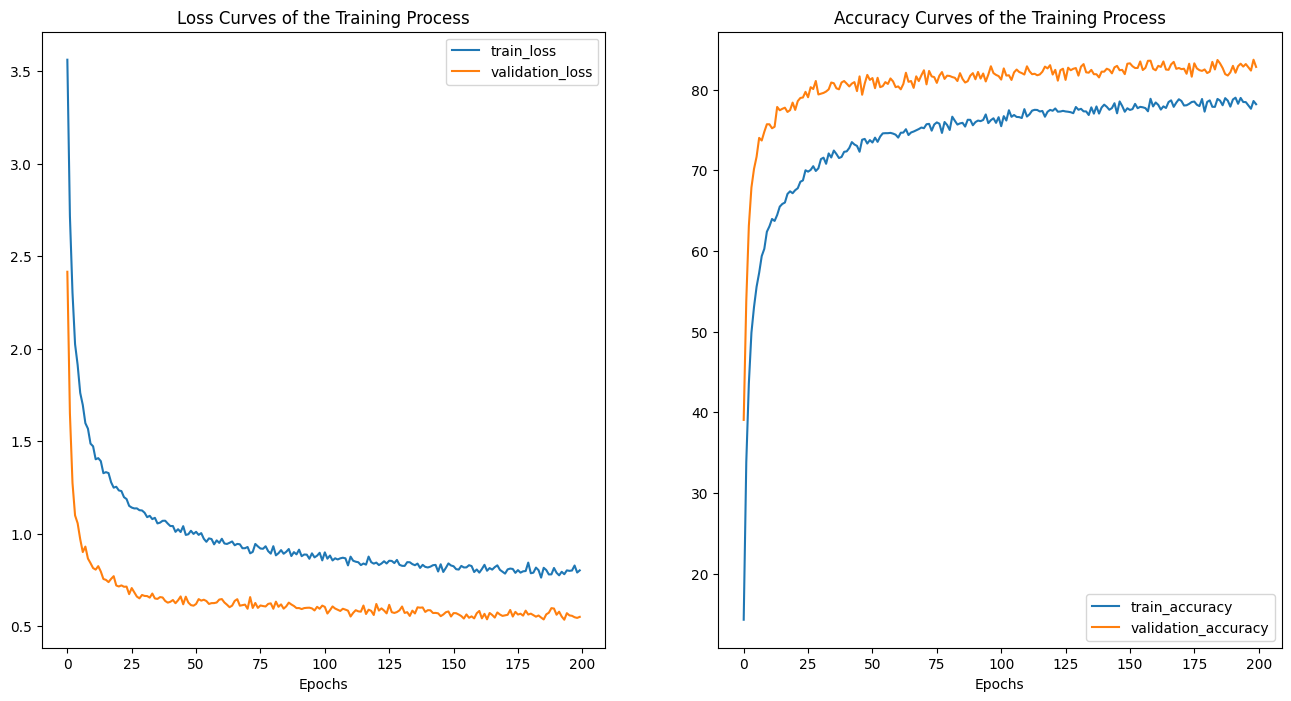

In [203]:
plot_loss_curves(model_v0_results)

ohh we'll be able to get pretty good accuracy on validation set but the main concern over here is that even after training the model for 200 epochs we won't get good accuracy on train data.

One thing is pretty clear that our model doesn't suffer from the concept of overfitting.

Let's try to train it for more number of epoch.

In [204]:
traffic_model_v1 = TrafficModelv0(
    input_shape=1,
    hidden_units=64,
    output_shape=len(class_names)
).to(device)

traffic_model_v1

TrafficModelv0(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=59, bias=True)
  )
)

In [205]:
summary(traffic_model_v1, input_size=[1, 1, 32, 32])

Layer (type:depth-idx)                   Output Shape              Param #
TrafficModelv0                           [1, 59]                   --
├─Sequential: 1-1                        [1, 32, 16, 16]           --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           640
│    └─ReLU: 2-2                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-3                       [1, 32, 32, 32]           18,464
│    └─ReLU: 2-4                         [1, 32, 32, 32]           --
│    └─MaxPool2d: 2-5                    [1, 32, 16, 16]           --
├─Sequential: 1-2                        [1, 16, 8, 8]             --
│    └─Conv2d: 2-6                       [1, 32, 16, 16]           9,248
│    └─ReLU: 2-7                         [1, 32, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 16, 16, 16]           4,624
│    └─ReLU: 2-9                         [1, 16, 16, 16]           --
│    └─MaxPool2d: 2-10                   [1, 16, 8, 8]             --
├─Se

In [206]:
optimizer = torch.optim.Adam(traffic_model_v1.parameters(), lr = 0.001)

In [208]:
EPOCHS = 500

from timeit import default_timer as timer

start_time = timer()

model_v1_results = train(
    model = traffic_model_v1,
    train_dataloader = train_dataloader,
    validation_dataloader = validation_dataloader,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 2.3412 Train Accuracy 42.2842 | Validation Loss 1.2844 Validation Accuracy 64.7449
Epoch 1 | Train Loss: 2.0623 Train Accuracy 48.8690 | Validation Loss 1.0653 Validation Accuracy 70.5293
Epoch 2 | Train Loss: 1.8626 Train Accuracy 53.8876 | Validation Loss 0.9903 Validation Accuracy 72.4362
Epoch 3 | Train Loss: 1.7425 Train Accuracy 55.5394 | Validation Loss 0.9520 Validation Accuracy 73.2143
Epoch 4 | Train Loss: 1.6483 Train Accuracy 58.3445 | Validation Loss 0.8879 Validation Accuracy 75.0383
Epoch 5 | Train Loss: 1.5736 Train Accuracy 60.2195 | Validation Loss 0.8567 Validation Accuracy 75.4528
Epoch 6 | Train Loss: 1.4977 Train Accuracy 62.1205 | Validation Loss 0.7921 Validation Accuracy 77.0855
Epoch 7 | Train Loss: 1.4504 Train Accuracy 62.7195 | Validation Loss 0.7554 Validation Accuracy 78.6480
Epoch 8 | Train Loss: 1.3726 Train Accuracy 64.0848 | Validation Loss 0.7473 Validation Accuracy 78.1186
Epoch 9 | Train Loss: 1.3552 Train Accuracy 64.7545 | V

In [ ]:
plot_loss_curves(model_v1_results)

Let's try to modify the model structure to make it more complex so that it'll be able to learn the training data more throughly.

In [305]:
class TrafficModelv1(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units, out_channels = int(hidden_units * 2), kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = int(hidden_units * 2), out_channels = int(hidden_units * 2), kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = int(hidden_units * 2), out_channels = int(hidden_units * 4), kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels = int(hidden_units * 4), out_channels = int(hidden_units * 4), kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = int(hidden_units * 4), out_channels = int(hidden_units * 8), kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(in_channels = int(hidden_units * 8), out_channels = int(hidden_units * 8), kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = int(hidden_units * 8), out_channels = int(hidden_units * 8), kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = int(hidden_units * 8)*2*2,
                      out_features = output_shape)
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_block_4(self.conv_block_3(self.conv_block_2(self.conv_block_1(x)))))

In [168]:
model_v2 = TrafficModelv1(
    input_shape=1,
    hidden_units=128,
    output_shape=len(class_names)
).to(device)

model_v2

TrafficModelv1(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_4): Sequential(
    (0): Conv2d(1024, 1024, kernel_size=(3,

In [169]:
from torchinfo import summary

summary(model_v2, input_size=[1, 1, 32, 32])

Layer (type:depth-idx)                   Output Shape              Param #
TrafficModelv1                           [1, 59]                   --
├─Sequential: 1-1                        [1, 256, 16, 16]          --
│    └─Conv2d: 2-1                       [1, 128, 32, 32]          1,280
│    └─ReLU: 2-2                         [1, 128, 32, 32]          --
│    └─Conv2d: 2-3                       [1, 256, 32, 32]          295,168
│    └─ReLU: 2-4                         [1, 256, 32, 32]          --
│    └─MaxPool2d: 2-5                    [1, 256, 16, 16]          --
├─Sequential: 1-2                        [1, 512, 8, 8]            --
│    └─Conv2d: 2-6                       [1, 256, 16, 16]          590,080
│    └─ReLU: 2-7                         [1, 256, 16, 16]          --
│    └─Conv2d: 2-8                       [1, 512, 16, 16]          1,180,160
│    └─ReLU: 2-9                         [1, 512, 16, 16]          --
│    └─MaxPool2d: 2-10                   [1, 512, 8, 8]          

In [170]:
img_batch, label_batch = next(iter(train_dataloader))

image, label = img_batch[0].unsqueeze(dim = 0), label_batch[0]

print(f"Image shape: {image.shape}")

model_v2.eval()
with torch.inference_mode():
    pred = model_v2(image.to(device))
    
print(f"Prediction Logits: \n{pred}")
print(f"\nPrediction Probabilities: \n{torch.softmax(pred, dim = 1)}")
print(f"\nPrediction Label: {torch.argmax(torch.softmax(pred, dim = 1), dim = 1).squeeze()}")
print(f"\nActual Label: {label}")

Image shape: torch.Size([1, 1, 32, 32])
Prediction Logits: 
tensor([[-0.0086, -0.0114,  0.0077,  0.0069, -0.0110,  0.0150,  0.0007, -0.0106,
          0.0094, -0.0056, -0.0101, -0.0079,  0.0126,  0.0017, -0.0132, -0.0153,
          0.0086,  0.0122, -0.0075,  0.0052,  0.0123,  0.0041,  0.0031,  0.0136,
          0.0115, -0.0031,  0.0162,  0.0077, -0.0087,  0.0087, -0.0127,  0.0094,
         -0.0009, -0.0105, -0.0057,  0.0109,  0.0131, -0.0032,  0.0099, -0.0116,
         -0.0123,  0.0134,  0.0112, -0.0088, -0.0110,  0.0141, -0.0060, -0.0062,
         -0.0129,  0.0094,  0.0021, -0.0106,  0.0095, -0.0049,  0.0100,  0.0116,
         -0.0085, -0.0145,  0.0058]], device='cuda:0')

Prediction Probabilities: 
tensor([[0.0168, 0.0167, 0.0171, 0.0171, 0.0168, 0.0172, 0.0169, 0.0168, 0.0171,
         0.0168, 0.0168, 0.0168, 0.0172, 0.0170, 0.0167, 0.0167, 0.0171, 0.0171,
         0.0168, 0.0170, 0.0171, 0.0170, 0.0170, 0.0172, 0.0171, 0.0169, 0.0172,
         0.0171, 0.0168, 0.0171, 0.0167, 0.0171

In [171]:
image_batch, label_batch = next(iter(train_dataloader))

model_v2.eval()
with torch.inference_mode():
    
    image_batch, label_batch = image_batch.to(device), label_batch.to(device)
    
    y_logits = model_v2(image_batch)
    y_pred = torch.argmax(torch.softmax(y_logits, dim = 1), dim = 1)
    
print(f"Prediction Logits: \n{y_logits}\nShape: {y_logits.shape}\nDatatype: {y_logits.dtype}")
print(f"\nPrediction Class: \n{y_pred}\nShape: {y_pred.shape}\nDatatype: {y_pred.dtype}")
print(f"\nActual Class: \n{label_batch}\nShape: {label_batch.shape}\nDatatype: {label_batch.dtype}")

Prediction Logits: 
tensor([[-0.0083, -0.0115,  0.0077,  ..., -0.0087, -0.0144,  0.0063],
        [-0.0085, -0.0116,  0.0076,  ..., -0.0085, -0.0144,  0.0059],
        [-0.0084, -0.0114,  0.0075,  ..., -0.0085, -0.0145,  0.0061],
        ...,
        [-0.0084, -0.0114,  0.0076,  ..., -0.0087, -0.0144,  0.0061],
        [-0.0085, -0.0111,  0.0078,  ..., -0.0085, -0.0147,  0.0059],
        [-0.0084, -0.0114,  0.0076,  ..., -0.0086, -0.0145,  0.0060]],
       device='cuda:0')
Shape: torch.Size([32, 59])
Datatype: torch.float32

Prediction Class: 
tensor([26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26,
        26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26, 26],
       device='cuda:0')
Shape: torch.Size([32])
Datatype: torch.int64

Actual Class: 
tensor([43, 15,  5,  0, 41, 53, 51, 10,  8, 51, 33, 40, 12, 57, 29, 53,  4,  8,
         3, 46, 14, 28, 53,  0, 58, 29, 10, 55, 51, 31, 34, 54],
       device='cuda:0')
Shape: torch.Size([32])
Datatype: torch.int64


In [172]:
loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v2.parameters(), lr = 0.001)

In [173]:
EPOCHS = 300

from timeit import default_timer as timer

start_time = timer()

model_v2_results = train(
    model = model_v2,
    train_dataloader = train_dataloader,
    validation_dataloader = validation_dataloader,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 3.8920 Train Accuracy 5.2902 | Validation Loss 3.3603 Validation Accuracy 13.3673
Epoch 1 | Train Loss: 3.1012 Train Accuracy 20.0260 | Validation Loss 1.8154 Validation Accuracy 45.8546
Epoch 2 | Train Loss: 2.2575 Train Accuracy 39.8028 | Validation Loss 1.2269 Validation Accuracy 62.5319
Epoch 3 | Train Loss: 1.8467 Train Accuracy 49.3341 | Validation Loss 1.0694 Validation Accuracy 67.1301
Epoch 4 | Train Loss: 1.5843 Train Accuracy 57.0685 | Validation Loss 0.8174 Validation Accuracy 72.4872
Epoch 5 | Train Loss: 1.4546 Train Accuracy 59.4792 | Validation Loss 0.6457 Validation Accuracy 77.7870
Epoch 6 | Train Loss: 1.2848 Train Accuracy 64.1741 | Validation Loss 0.6368 Validation Accuracy 79.3495
Epoch 7 | Train Loss: 1.2491 Train Accuracy 64.9665 | Validation Loss 0.5628 Validation Accuracy 80.3125
Epoch 8 | Train Loss: 1.1685 Train Accuracy 67.1615 | Validation Loss 0.5393 Validation Accuracy 80.6441
Epoch 9 | Train Loss: 1.0998 Train Accuracy 68.3110 | Va

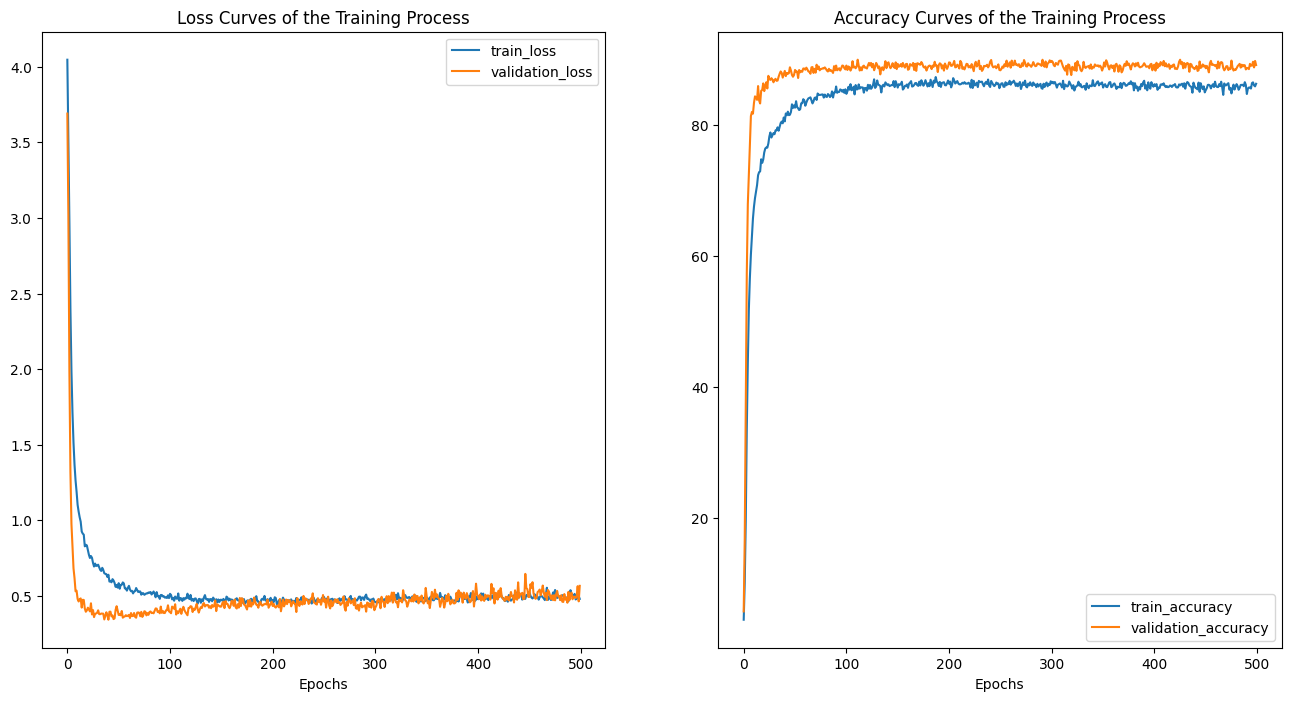

In [50]:
plot_loss_curves(model_v2_results)

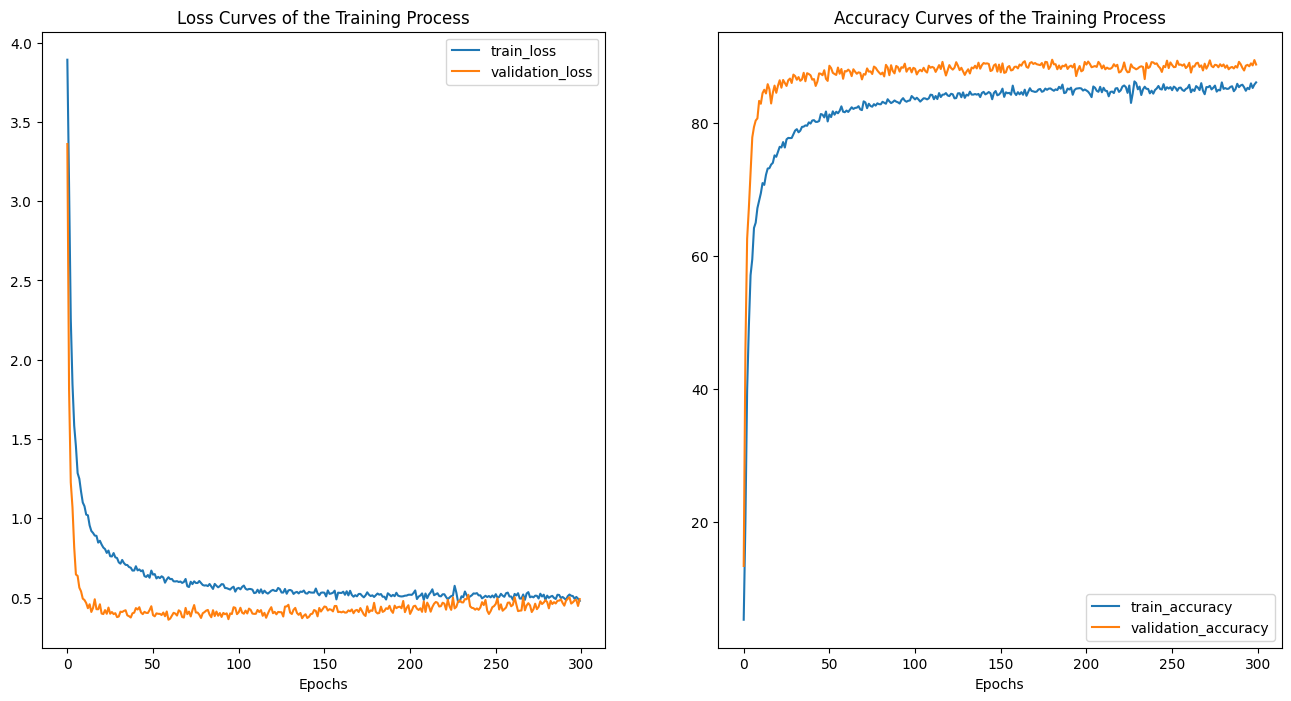

In [174]:
plot_loss_curves(model_v2_results)

In [27]:
def evaluate_model(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fun: nn.Module,
    accuracy_fun
):
    model.eval()

    total_loss, total_accuracy = 0, 0
    actual_values = []
    predictions = []

    with torch.inference_mode():

        for batch, (X, y) in enumerate(dataloader):

            X, y = X.to(device), y.to(device)

            y_logits = model(X)
            y_pred = torch.argmax(y_logits, dim=1)

            loss = loss_fun(y_logits, y)
            total_loss += loss.item()
            total_accuracy += accuracy_fun(y_true=y, y_pred=y_pred)

            actual_values.extend(y.cpu().numpy())
            predictions.extend(y_pred.cpu().numpy())

        total_loss = total_loss / len(dataloader)
        total_accuracy = total_accuracy / len(dataloader)

    print(f"Final accuracy of the model is {total_accuracy:.4f} % with loss of {total_loss:.4f}")
    
    return actual_values, predictions, total_loss, total_accuracy

In [231]:
actual_values, predictions = evaluate_model(model = model_v2, dataloader = test_dataloader, loss_fun = loss_fun, accuracy_fun = accuracy_fun)

Final accuracy of the model is 88.4975 % with loss of 0.5137


In [232]:
actual_values = np.array(actual_values)
predictions = np.array(predictions)

In [233]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay

precison = precision_score(y_true=actual_values, y_pred=predictions, average='weighted')
recall = recall_score(y_true=actual_values, y_pred=predictions, average='weighted')
f1 = f1_score(y_true=actual_values, y_pred=predictions, average='weighted')
report = classification_report(y_true=actual_values, y_pred=predictions)

print(f"Precision score: {precison:.4f}\n")
print(f"Recall score: {recall:.4f}\n")
print(f"F1 score: {f1:.4f}\n")
print(f"Classification report:\n{report}")

Precision score: 0.8914

Recall score: 0.8848

F1 score: 0.8851

Classification report:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93        40
           1       0.98      1.00      0.99        40
           2       0.77      0.85      0.81        40
           3       0.85      0.72      0.78        40
           4       1.00      0.97      0.99        40
           5       1.00      0.88      0.93        65
           6       0.95      0.97      0.96        40
           7       0.95      0.90      0.92        40
           8       0.97      0.95      0.96       121
           9       0.97      0.97      0.97        40
          10       0.97      0.95      0.96        40
          11       0.95      1.00      0.98        40
          12       1.00      0.97      0.99        40
          13       0.97      0.95      0.96        41
          14       0.97      0.90      0.94        40
          15       0.95      0.97      0.96    

Let's inspect the class of images having low f1 score for both train and test datasets to get the idea about data with respect to that particular category.

In [180]:
class_with_low_f1_score = [2, 3, 20, 23, 24, 25, 26, 36, 37, 42, 43, 47, 48, 49]

print(f"These classes have low F1 score: (total class - {len(class_with_low_f1_score)})\n{class_with_low_f1_score}")

These classes have low F1 score: (total class - 14)
[2, 3, 20, 23, 24, 25, 26, 36, 37, 42, 43, 47, 48, 49]


In [202]:
inspect_class_images_for_train_data = []

for i in range(len(train_dataset)):
    x = train_dataset[i]
    if x[1] in class_with_low_f1_score:
        inspect_class_images.append(x)

In [28]:
def plot_random_images(image_data: List[tuple]):
    
    cols = 5
    no_of_classes = len(class_with_low_f1_score)

    fig, ax = plt.subplots(nrows = no_of_classes, ncols = cols, figsize = (10, 20))
    fig.tight_layout()

    for j, class_name in enumerate(class_with_low_f1_score):
        count = 0
        for x in inspect_class_images:
            if x[1] == class_name:
                if count != 5:
                    img = np.asarray(x[0].permute(1, 2, 0))
                    ax[j][count].imshow(img, cmap="gray")
                    ax[j][count].axis('off')
                    if count == 2:
                        ax[j][count].set_title(str(class_name))
                    count += 1
                else:
                    break

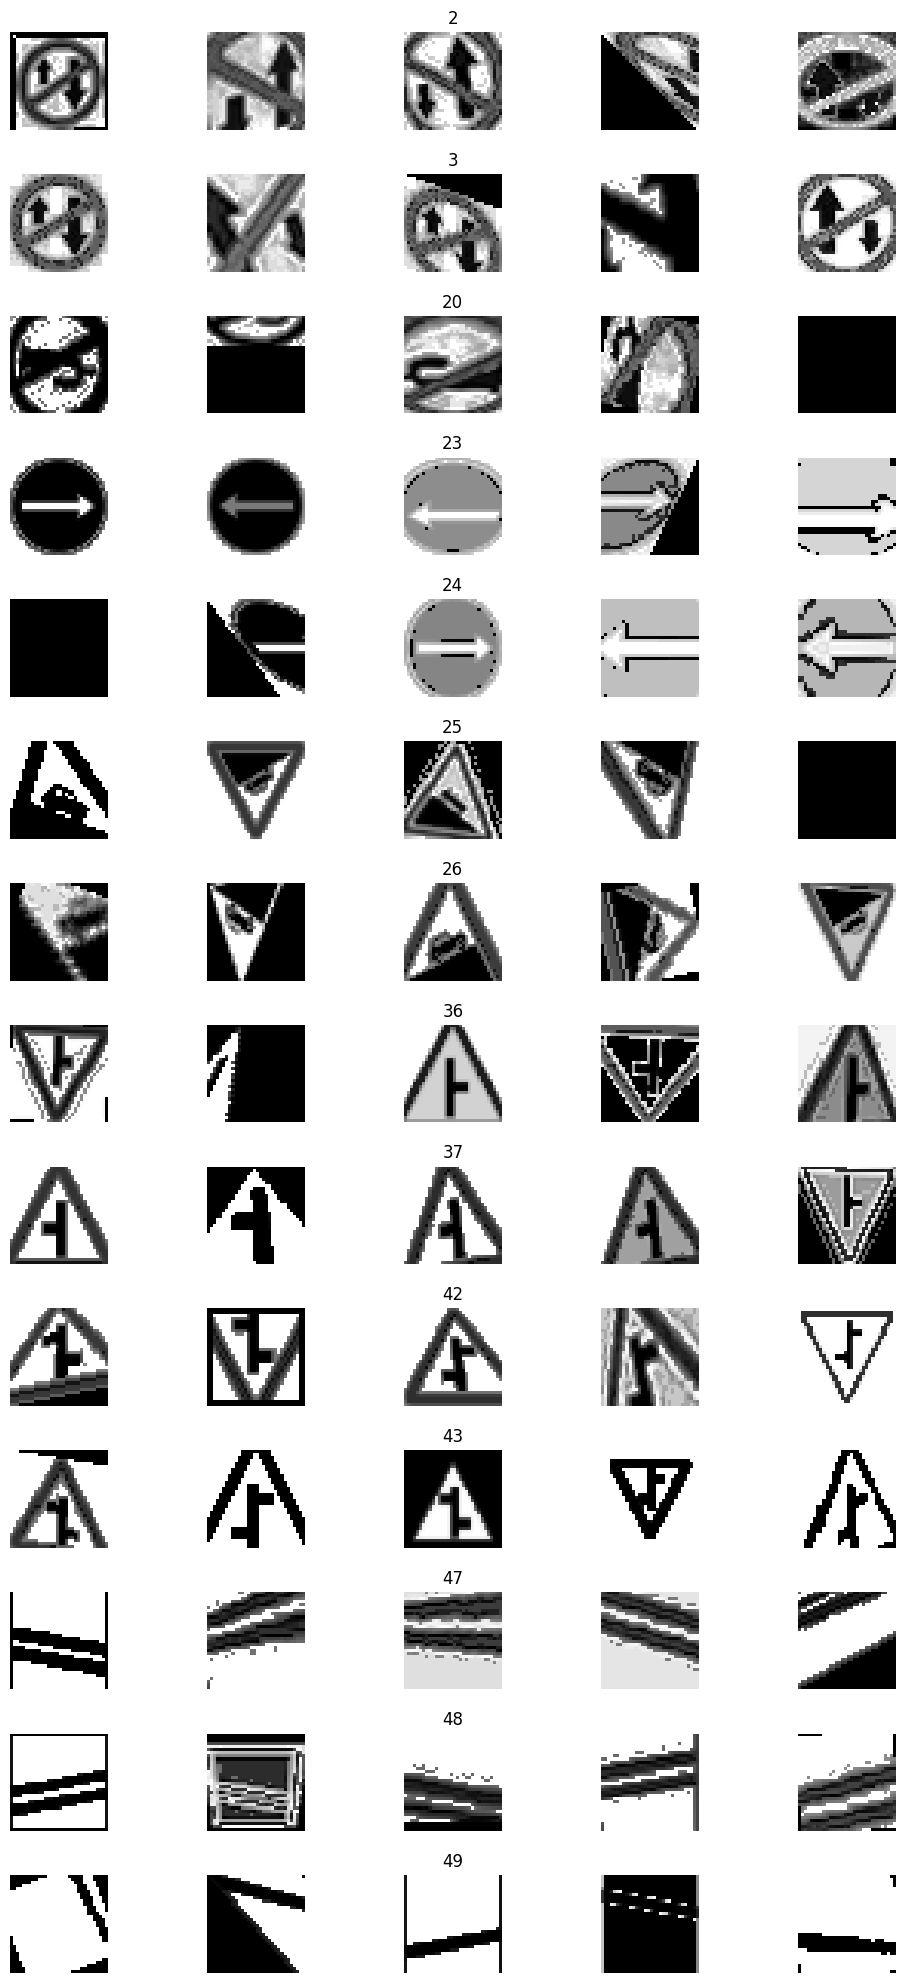

In [204]:
plot_random_images(inspect_class_images)

It seems like there are certain images in train dataset having completely black color that doesn't make any sense at all.

In [205]:
inspect_class_images_for_test_data = []

for i in range(len(test_dataset)):
    x = test_dataset[i]
    if x[1] in class_with_low_f1_score:
        inspect_class_images.append(x)

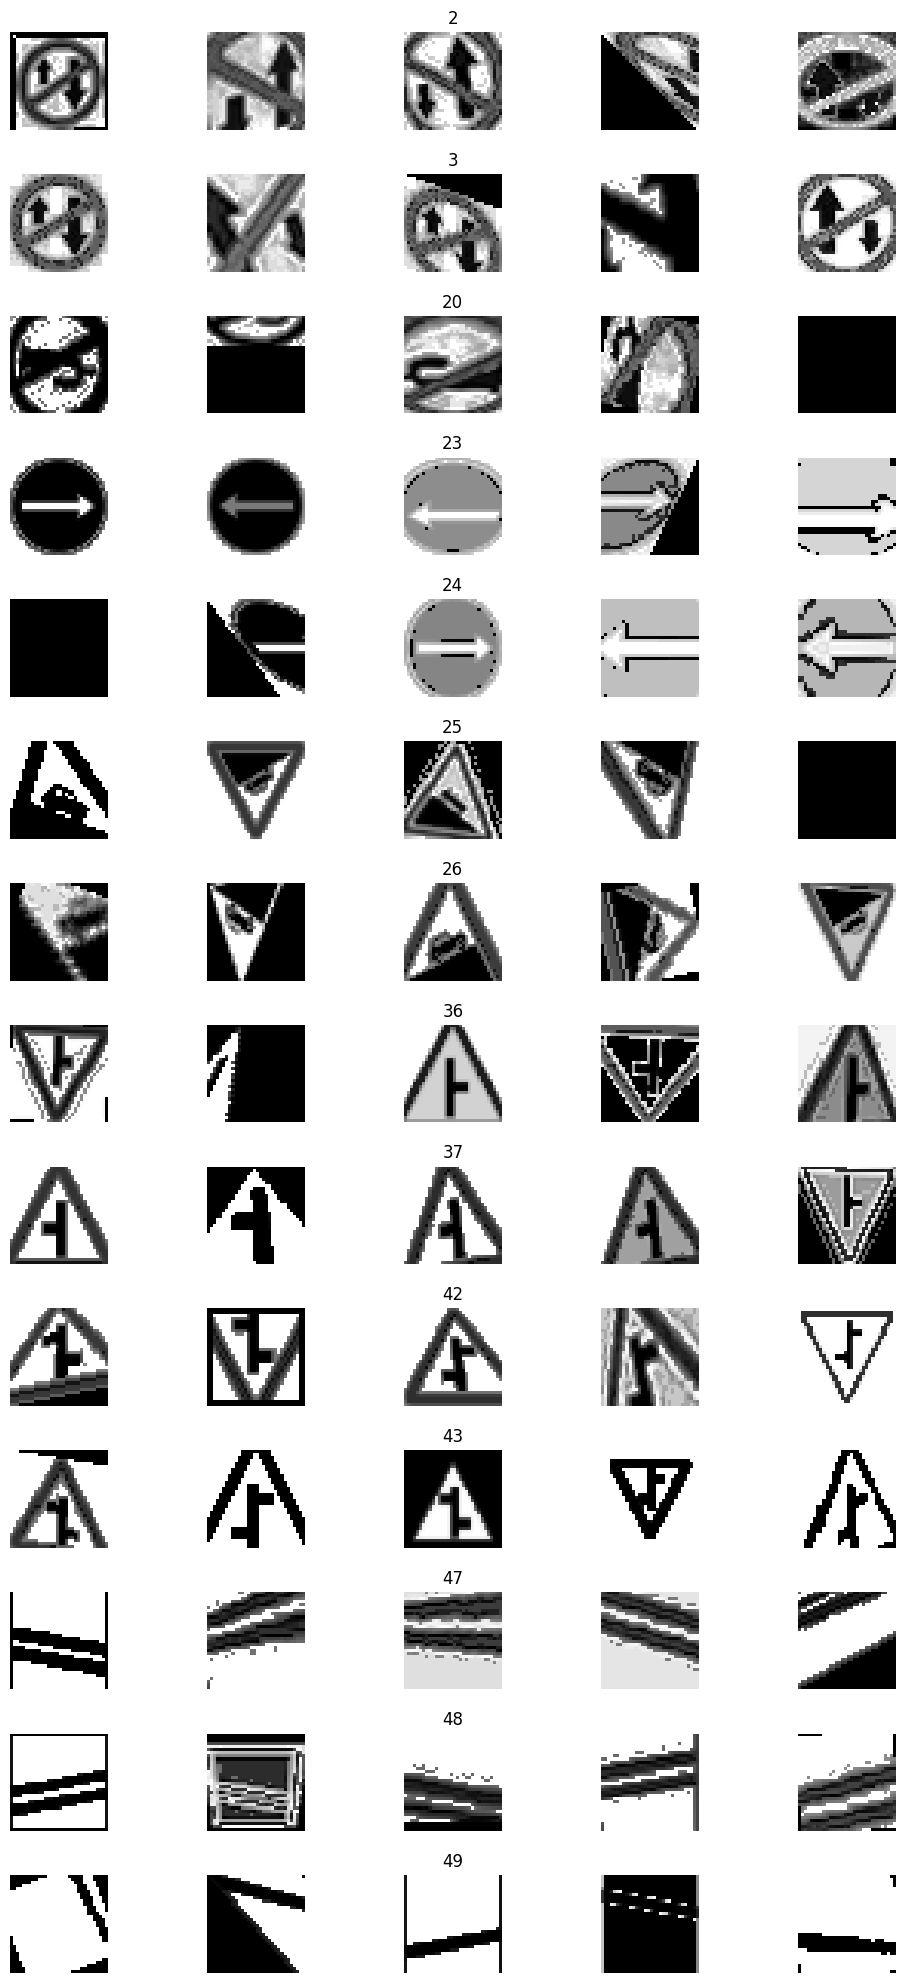

In [207]:
plot_random_images(inspect_class_images_for_test_data)

ohh it seems we also have completely black images in our test dataset as well.

In [8]:
class OpenCVTransformation:
    def __init__(self):
        pass
    
    def __call__(self, img):
        
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        
        return img

In [9]:
modified_train_data_transformation = transforms.Compose([
    OpenCVTransformation(),
    transforms.ToPILImage(),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor(),
])

modified_test_data_transformation = transforms.Compose([
    OpenCVTransformation(),
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

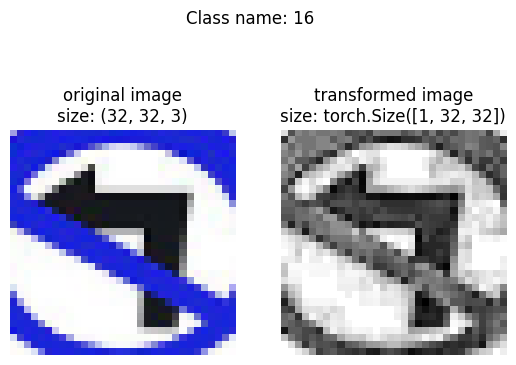

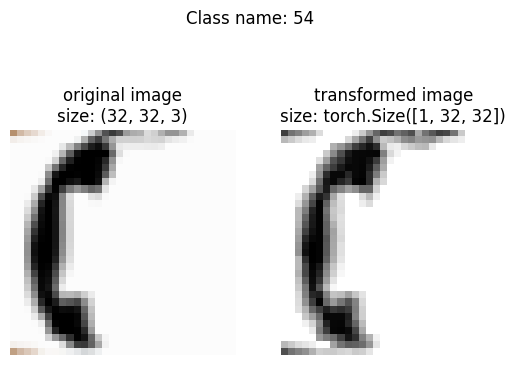

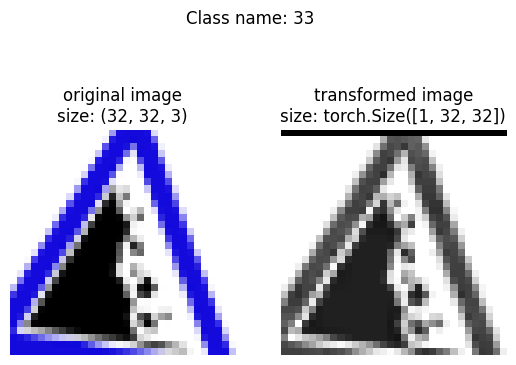

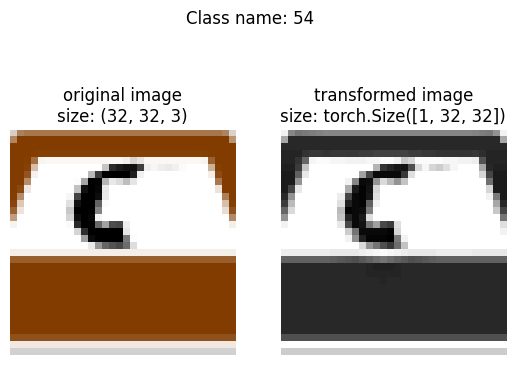

In [32]:
plot_transformed_images(image_paths = train_image_path_list, transform = modified_train_data_transformation)

In [33]:
modified_train_dataset = CustomDataset(root_dir = image_path, image_paths = train_image_path_list, transform = modified_train_data_transformation)
modified_validation_dataset = CustomDataset(root_dir = image_path, image_paths = validation_image_path_list, transform = modified_test_data_transformation)
modified_test_dataset = CustomDataset(root_dir = image_path, image_paths = test_image_path_list, transform = modified_test_data_transformation)

print(f"Number of train images examples: {len(modified_train_dataset)}")
print(f"Number of test images examples: {len(modified_test_dataset)}")
print(f"Number of validation examples: {len(modified_validation_dataset)}")

Number of train images examples: 10058
Number of test images examples: 2795
Number of validation examples: 1118


Image Tensor:
tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
         ...,
         [0.2353, 0.2196, 0.2039,  ..., 0.0000, 0.0000, 0.0000],
         [0.4706, 0.6863, 0.8588,  ..., 0.0000, 0.0000, 0.0000],
         [1.0000, 1.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000]]])
Shape of image: torch.Size([1, 32, 32])
Datatype of image: torch.float32
Label: 7
Label datatype: <class 'int'>


(-0.5, 31.5, 31.5, -0.5)

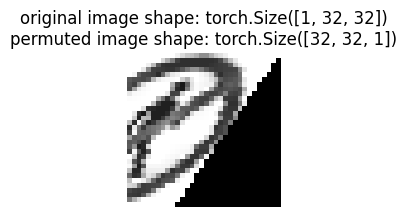

In [34]:
image, label = modified_train_dataset[50]

print(f"Image Tensor:\n{image}")
print(f"Shape of image: {image.shape}")
print(f"Datatype of image: {image.dtype}")
print(f"Label: {label}")
print(f"Label datatype: {type(label)}")

img = image.permute(1, 2, 0)

plt.figure(figsize=(4, 2))
plt.imshow(img, cmap='gray')
plt.title(f"original image shape: {image.shape}\npermuted image shape: {img.shape}")
plt.axis(False)

In [32]:
## Converting train, validation and test datasets into dataloader objects
modified_train_dataloader = DataLoader(
    dataset = modified_train_dataset,
    batch_size = 32,
    num_workers = os.cpu_count(),
    shuffle = True
)

modified_validation_dataloader = DataLoader(
    dataset = modified_validation_dataset,
    batch_size = 32,
    num_workers = os.cpu_count(),
    shuffle = False
)

modified_test_dataloader = DataLoader(
    dataset = modified_test_dataset,
    batch_size = 32,
    num_workers = os.cpu_count(),
    shuffle = False
)

modified_train_dataloader, modified_validation_dataloader, modified_test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7a690938e0e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a690938c310>)

In [33]:
img, label = next(iter(modified_train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channel, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 1, 32, 32]) -> [batch_size, color_channel, height, width]
Label shape: torch.Size([32])


If you want to display the images then n should be less then or equal to 5. converting it to n and removing the shape display.


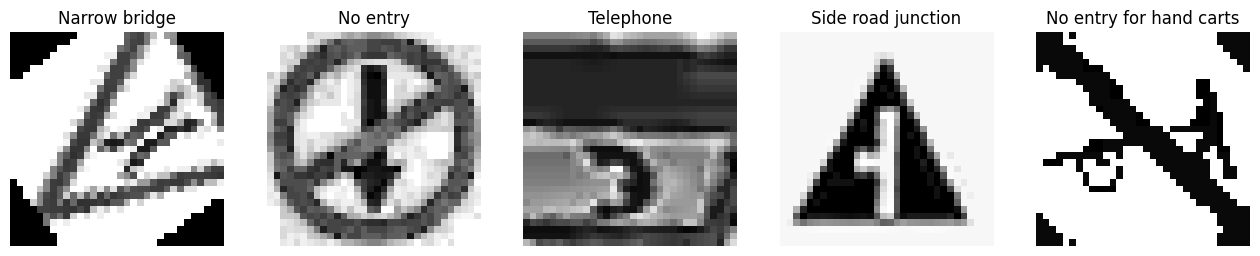

In [36]:
display_random_images(
    dataset = modified_train_dataset,
    classes = class_names,
    n = 10
)

Let's change the model architecture.

In [10]:
class TrafficModelv2(nn.Module):
    def __init__(self, input_shape: int, output_shape: int, hidden_units: int):
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels = input_shape, out_channels = hidden_units, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = hidden_units, out_channels = int(hidden_units * 2), kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels = int(hidden_units * 2), out_channels = int(hidden_units * 2), kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = int(hidden_units * 2), out_channels = int(hidden_units * 4), kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels = int(hidden_units * 4), out_channels = int(hidden_units * 4), kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = int(hidden_units * 4), out_channels = int(hidden_units * 8), kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features = int(hidden_units * 8)*4*4, out_features = 1024),
            nn.Linear(in_features = 1024, out_features = 128),
            nn.Linear(in_features = 128, out_features = 196),
            nn.Linear(in_features = 196, out_features = output_shape)
        )
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(x))))

In [110]:
model_v3 = TrafficModelv2(
    input_shape = 1,
    hidden_units = 128,
    output_shape = len(class_names)
).to(device)

model_v3

TrafficModelv2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
   

In [111]:
summary(model_v3, input_size = (1, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
TrafficModelv2                           [1, 59]                   --
├─Sequential: 1-1                        [1, 256, 16, 16]          --
│    └─Conv2d: 2-1                       [1, 128, 32, 32]          1,280
│    └─ReLU: 2-2                         [1, 128, 32, 32]          --
│    └─Conv2d: 2-3                       [1, 256, 32, 32]          295,168
│    └─ReLU: 2-4                         [1, 256, 32, 32]          --
│    └─MaxPool2d: 2-5                    [1, 256, 16, 16]          --
├─Sequential: 1-2                        [1, 512, 8, 8]            --
│    └─Conv2d: 2-6                       [1, 256, 16, 16]          590,080
│    └─ReLU: 2-7                         [1, 256, 16, 16]          --
│    └─Conv2d: 2-8                       [1, 512, 16, 16]          1,180,160
│    └─ReLU: 2-9                         [1, 512, 16, 16]          --
│    └─MaxPool2d: 2-10                   [1, 512, 8, 8]          

In [112]:
EPOCHS = 500

from timeit import default_timer as timer

loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v3.parameters(), lr = 0.001)

start_time = timer()

model_v3_results = train(
    model = model_v3,
    train_dataloader = modified_train_dataloader,
    validation_dataloader = modified_validation_dataloader,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 3.9048 Train Accuracy 5.9867 | Validation Loss 3.2519 Validation Accuracy 15.9297
Epoch 1 | Train Loss: 3.2286 Train Accuracy 17.2786 | Validation Loss 2.1999 Validation Accuracy 36.2478
Epoch 2 | Train Loss: 2.5471 Train Accuracy 31.9986 | Validation Loss 1.5176 Validation Accuracy 52.8166
Epoch 3 | Train Loss: 2.0692 Train Accuracy 43.3876 | Validation Loss 1.0641 Validation Accuracy 66.8218
Epoch 4 | Train Loss: 1.7920 Train Accuracy 50.7200 | Validation Loss 0.9726 Validation Accuracy 70.5230
Epoch 5 | Train Loss: 1.5753 Train Accuracy 55.3880 | Validation Loss 0.7556 Validation Accuracy 75.3675


KeyboardInterrupt: 

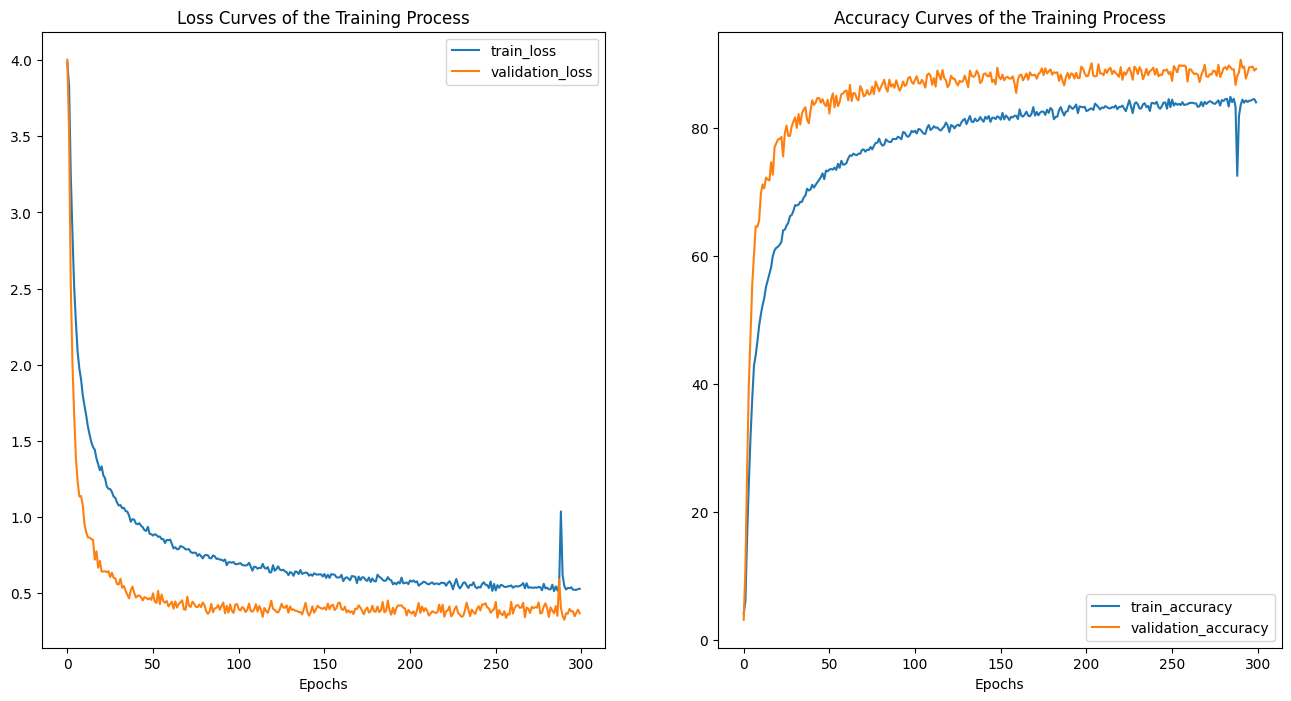

In [141]:
plot_loss_curves(model_v3_results)

In [147]:
actual_values, predictions, total_loss, total_accuracy = evaluate_model(model = model_v3, dataloader = modified_test_dataloader, loss_fun = loss_fun, accuracy_fun = accuracy_fun)

Final accuracy of the model is 88.3942 % with loss of 0.4261


In [143]:
actual_values = np.array(actual_values)
predictions = np.array(predictions)

In [144]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay

precison = precision_score(y_true=actual_values, y_pred=predictions, average='weighted')
recall = recall_score(y_true=actual_values, y_pred=predictions, average='weighted')
f1 = f1_score(y_true=actual_values, y_pred=predictions, average='weighted')
report = classification_report(y_true=actual_values, y_pred=predictions)

print(f"Precision score: {precison:.4f}\n")
print(f"Recall score: {recall:.4f}\n")
print(f"F1 score: {f1:.4f}\n")
print(f"Classification report:\n{report}")

Precision score: 0.8994

Recall score: 0.8844

F1 score: 0.8884

Classification report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        40
           1       0.93      1.00      0.96        40
           2       0.72      0.85      0.78        40
           3       0.82      0.68      0.74        40
           4       1.00      0.93      0.96        40
           5       0.95      0.92      0.94        65
           6       0.93      0.95      0.94        40
           7       0.97      0.90      0.94        40
           8       0.98      0.98      0.98       121
           9       1.00      0.95      0.97        40
          10       1.00      0.97      0.99        40
          11       0.97      0.97      0.97        40
          12       0.97      0.95      0.96        40
          13       1.00      0.95      0.97        41
          14       1.00      0.88      0.93        40
          15       0.91      1.00      0.95    

Let's try to change the batch size to see if makes any difference.

In [113]:
## Converting train, validation and test datasets into dataloader objects
modified_train_dataloader = DataLoader(
    dataset = modified_train_dataset,
    batch_size = 64,
    num_workers = os.cpu_count(),
    shuffle = True
)

modified_validation_dataloader = DataLoader(
    dataset = modified_validation_dataset,
    batch_size = 64,
    num_workers = os.cpu_count(),
    shuffle = False
)

modified_test_dataloader = DataLoader(
    dataset = modified_test_dataset,
    batch_size = 64,
    num_workers = os.cpu_count(),
    shuffle = False
)

modified_train_dataloader, modified_validation_dataloader, modified_test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e7c84550880>,
 <torch.utils.data.dataloader.DataLoader at 0x7e7c845501c0>)

In [114]:
img, label = next(iter(modified_train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channel, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([64, 1, 32, 32]) -> [batch_size, color_channel, height, width]
Label shape: torch.Size([64])


If you want to display the images then n should be less then or equal to 5. converting it to n and removing the shape display.


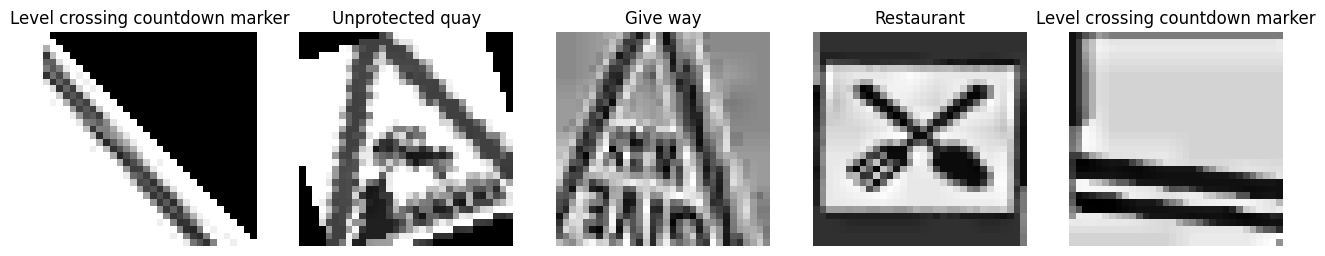

In [57]:
display_random_images(
    dataset = modified_train_dataset,
    classes = class_names,
    n = 10
)

In [115]:
model_v4 = TrafficModelv2(
    input_shape = 1,
    hidden_units = 128,
    output_shape = len(class_names)
).to(device)

model_v4

TrafficModelv2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
   

In [116]:
summary(model_v4, input_size = (1, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
TrafficModelv2                           [1, 59]                   --
├─Sequential: 1-1                        [1, 256, 16, 16]          --
│    └─Conv2d: 2-1                       [1, 128, 32, 32]          1,280
│    └─ReLU: 2-2                         [1, 128, 32, 32]          --
│    └─Conv2d: 2-3                       [1, 256, 32, 32]          295,168
│    └─ReLU: 2-4                         [1, 256, 32, 32]          --
│    └─MaxPool2d: 2-5                    [1, 256, 16, 16]          --
├─Sequential: 1-2                        [1, 512, 8, 8]            --
│    └─Conv2d: 2-6                       [1, 256, 16, 16]          590,080
│    └─ReLU: 2-7                         [1, 256, 16, 16]          --
│    └─Conv2d: 2-8                       [1, 512, 16, 16]          1,180,160
│    └─ReLU: 2-9                         [1, 512, 16, 16]          --
│    └─MaxPool2d: 2-10                   [1, 512, 8, 8]          

In [117]:
EPOCHS = 500

from timeit import default_timer as timer

loss_fun = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_v4.parameters(), lr = 0.001)

start_time = timer()

model_v4_results = train(
    model = model_v4,
    train_dataloader = modified_train_dataloader,
    validation_dataloader = modified_validation_dataloader,
    loss_fun = loss_fun,
    optimizer = optimizer,
    accuracy_fun = accuracy_fun,
    epochs = EPOCHS
)

end_time = timer()

print(f"Total training time: {end_time - start_time}")

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | Train Loss: 3.9166 Train Accuracy 5.3916 | Validation Loss 3.3681 Validation Accuracy 13.5880
Epoch 1 | Train Loss: 3.3478 Train Accuracy 15.2334 | Validation Loss 2.3587 Validation Accuracy 34.1146
Epoch 2 | Train Loss: 2.6972 Train Accuracy 28.1685 | Validation Loss 1.7749 Validation Accuracy 46.8229
Epoch 3 | Train Loss: 2.2868 Train Accuracy 39.0091 | Validation Loss 1.4261 Validation Accuracy 55.2546
Epoch 4 | Train Loss: 1.9569 Train Accuracy 46.2678 | Validation Loss 0.9963 Validation Accuracy 66.2269
Epoch 5 | Train Loss: 1.7422 Train Accuracy 51.0225 | Validation Loss 0.7574 Validation Accuracy 73.7674
Epoch 6 | Train Loss: 1.5741 Train Accuracy 56.4221 | Validation Loss 0.6936 Validation Accuracy 77.9456
Epoch 7 | Train Loss: 1.4247 Train Accuracy 59.6183 | Validation Loss 0.6867 Validation Accuracy 76.9271
Epoch 8 | Train Loss: 1.2940 Train Accuracy 62.9233 | Validation Loss 0.6345 Validation Accuracy 79.0972
Epoch 9 | Train Loss: 1.2958 Train Accuracy 62.7809 | Va

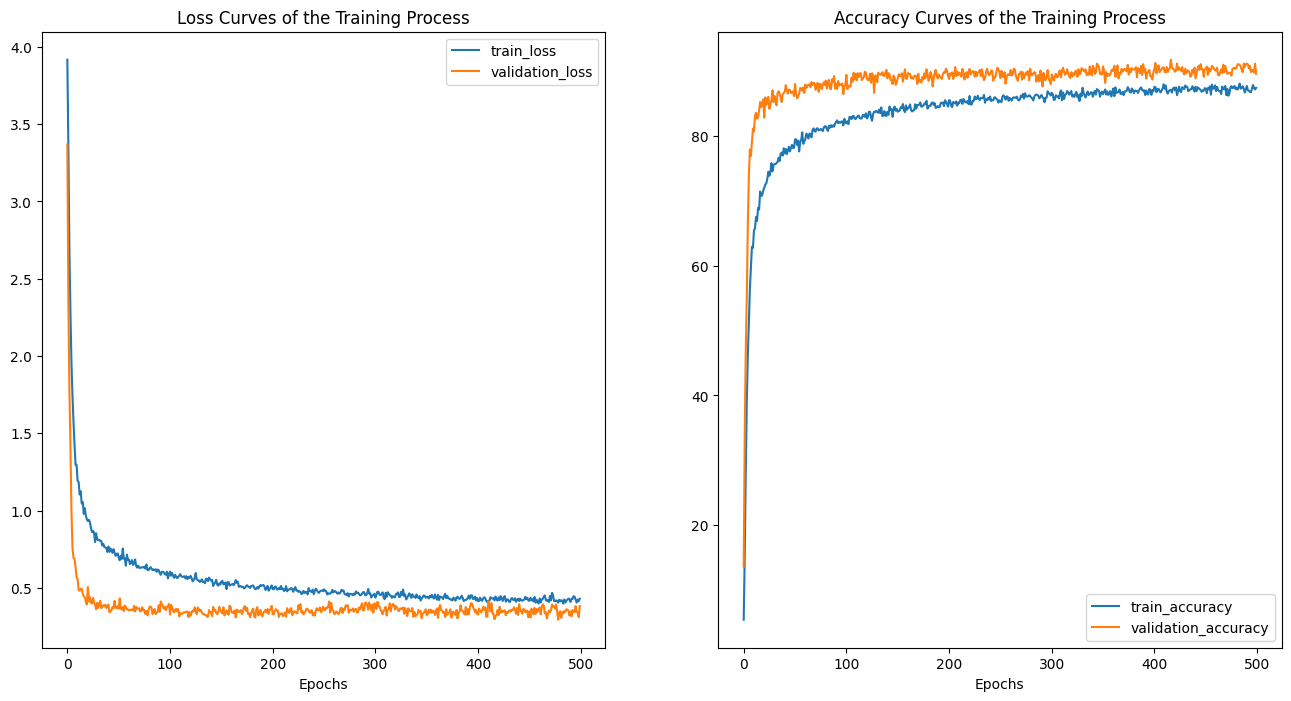

In [118]:
plot_loss_curves(model_v4_results)

In [119]:
actual_values, predictions, total_loss, total_accuracy = evaluate_model(model = model_v4, dataloader = modified_test_dataloader, loss_fun = loss_fun, accuracy_fun = accuracy_fun)

Final accuracy of the model is 89.4201 % with loss of 0.4108


In [120]:
actual_values = np.array(actual_values)
predictions = np.array(predictions)

In [121]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, ConfusionMatrixDisplay

precison = precision_score(y_true=actual_values, y_pred=predictions, average='weighted')
recall = recall_score(y_true=actual_values, y_pred=predictions, average='weighted')
f1 = f1_score(y_true=actual_values, y_pred=predictions, average='weighted')
report = classification_report(y_true=actual_values, y_pred=predictions)

print(f"Precision score: {precison:.4f}\n")
print(f"Recall score: {recall:.4f}\n")
print(f"F1 score: {f1:.4f}\n")
print(f"Classification report:\n{report}")

Precision score: 0.9095

Recall score: 0.8945

F1 score: 0.8959

Classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        40
           1       0.98      1.00      0.99        40
           2       0.86      0.60      0.71        40
           3       0.68      0.85      0.76        40
           4       0.95      0.97      0.96        40
           5       1.00      0.91      0.95        65
           6       1.00      0.93      0.96        40
           7       1.00      0.85      0.92        40
           8       0.98      0.98      0.98       121
           9       0.95      1.00      0.98        40
          10       0.98      1.00      0.99        40
          11       1.00      1.00      1.00        40
          12       0.95      0.97      0.96        40
          13       0.98      0.98      0.98        41
          14       1.00      0.88      0.93        40
          15       0.98      1.00      0.99    

In [123]:
torch.save({
    "test_accuracy" : total_accuracy,
    "test_loss" : total_loss,
    "model_state_dict" : model_v4.state_dict()
}, "model.pth")

Now Let's apply one more final thing to check if we're able to achieve more higher performace for our problem to classify the images of different traffic sign. 

I'm talking about **Transfer Learning**.

We'll be using EfficientNet_BX model as a base model.

In [78]:
import torchvision.models as tm

## Getting the default weights for the EfficientNet Model
default_weights = tm.EfficientNet_B0_Weights.DEFAULT

## Getting the model
pretrained_model = tm.efficientnet_b0(weights = default_weights).to(device)

pretrained_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [71]:
## Checking the default transformation for the pretrained model
default_transformation = default_weights.transforms()
default_transformation

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [81]:
manual_train_default_transformation = transforms.Compose([
    transforms.Resize(256, interpolation = transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.TrivialAugmentWide(num_magnitude_bins = 31),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

manual_test_default_transformation = transforms.Compose([
    transforms.Resize(256, interpolation = transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

manual_train_default_transformation, manual_test_default_transformation

(Compose(
     Resize(size=256, interpolation=bicubic, max_size=None, antialias=warn)
     CenterCrop(size=(224, 224))
     TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 Compose(
     Resize(size=256, interpolation=bicubic, max_size=None, antialias=warn)
     CenterCrop(size=(224, 224))
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ))

In [11]:
plot_transformed_images(image_paths = train_image_path_list, transform = manual_train_default_transformation)

In [89]:
from torch.utils.data import Dataset
from PIL import Image

class CustomDatasetv2(Dataset):
    def __init__(self, root_dir: str, image_paths: List[Path], transform: None) -> None:
        self.paths = image_paths
        self.transform = transform
        self.classes, self.class_to_idx = find_classes(dir_path = root_dir)
        
    def __len__(self) -> int:
        return len(self.paths)
    
    def load_image(self, idx) -> Image.Image:
        path = self.paths[idx]
        img = Image.open(path)
        return img
        
    def __getitem__(self, idx) -> Tuple[torch.Tensor, int]:
        img = self.load_image(idx)
        class_name = self.paths[idx].parent.name
        
        if self.transform:
            img = self.transform(img)
            
        return img, int(class_name)

In [90]:
default_train_dataset = CustomDatasetv2(root_dir = image_path, image_paths = train_image_path_list, transform = manual_train_default_transformation)
default_validation_dataset = CustomDatasetv2(root_dir = image_path, image_paths = validation_image_path_list, transform = manual_test_default_transformation)
default_test_dataset = CustomDatasetv2(root_dir = image_path, image_paths = test_image_path_list, transform = manual_test_default_transformation)

print(f"Number of images in train dataset: {len(default_train_dataset)}")
print(f"Number of images in validation dataset: {len(default_validation_dataset)}")
print(f"Number of images in test dataset: {len(default_test_dataset)}")

Number of images in train dataset: 10058
Number of images in validation dataset: 1118
Number of images in test dataset: 2795


In [91]:
default_train_dataloader = DataLoader(
    dataset = default_train_dataset,
    batch_size = 64,
    num_workers = os.cpu_count(),
    shuffle = True
)

default_validation_dataloader = DataLoader(
    dataset = default_validation_dataset,
    batch_size = 64,
    num_workers = os.cpu_count(),
    shuffle = False
)

default_test_dataloader = DataLoader(
    dataset = default_test_dataset,
    batch_size = 64,
    num_workers = os.cpu_count(),
    shuffle = False
)

default_train_dataloader, default_validation_dataloader, default_test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7e7cb88dfd60>,
 <torch.utils.data.dataloader.DataLoader at 0x7e7cb88de170>)

In [12]:
img, label = next(iter(default_train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channel, height, width]")
print(f"Label shape: {label.shape}")

In [76]:
summary(model = pretrained_model, col_names = ["input_size", "output_size", "num_params", "trainable"], col_width =20, row_settings = ["var_names"], input_size = (64, 3, 224, 224))

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 224, 224]    [64, 1000]           --                   True
├─Sequential (features)                                      [64, 3, 224, 224]    [64, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [64, 3, 224, 224]    [64, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [64, 3, 224, 224]    [64, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [64, 32, 112, 112]   [64, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [64, 32, 112, 112]   [64, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [64, 32, 112, 112]   [64, 16, 112

Let's make prediction on a custom Traffic sign image.

In [22]:
model = TrafficModelv2(
    input_shape = 1, 
    hidden_units = 128,
    output_shape = 59
).to(device)

model

TrafficModelv2(
  (conv_block_1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
   

In [25]:
summary(model, input_size=(1, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
TrafficModelv2                           [1, 59]                   --
├─Sequential: 1-1                        [1, 256, 16, 16]          --
│    └─Conv2d: 2-1                       [1, 128, 32, 32]          1,280
│    └─ReLU: 2-2                         [1, 128, 32, 32]          --
│    └─Conv2d: 2-3                       [1, 256, 32, 32]          295,168
│    └─ReLU: 2-4                         [1, 256, 32, 32]          --
│    └─MaxPool2d: 2-5                    [1, 256, 16, 16]          --
├─Sequential: 1-2                        [1, 512, 8, 8]            --
│    └─Conv2d: 2-6                       [1, 256, 16, 16]          590,080
│    └─ReLU: 2-7                         [1, 256, 16, 16]          --
│    └─Conv2d: 2-8                       [1, 512, 16, 16]          1,180,160
│    └─ReLU: 2-9                         [1, 512, 16, 16]          --
│    └─MaxPool2d: 2-10                   [1, 512, 8, 8]          

In [26]:
x = torch.load('/kaggle/input/best_model/pytorch/default/1/model.pth')

model.load_state_dict(x['model_state_dict'])
model.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[-1.0977e-01, -1.1439e-01, -5.3861e-02],
                        [ 8.5095e-02, -3.2046e-02, -1.7604e-01],
                        [-2.7913e-01, -9.9844e-02, -2.4693e-02]]],
              
              
                      [[[-7.9321e-02, -9.7412e-02, -2.9635e-01],
                        [-9.7381e-02,  8.2954e-02, -2.4678e-01],
                        [-3.8548e-02, -2.1291e-01,  4.4881e-04]]],
              
              
                      [[[-3.5988e-02, -4.0491e-01, -1.3177e-01],
                        [ 2.1076e-02, -9.0930e-02, -5.1289e-02],
                        [ 1.6920e-02, -3.7180e-01,  3.7727e-02]]],
              
              
                      ...,
              
              
                      [[[-2.3715e-01,  1.6456e-01,  4.1405e-02],
                        [-2.8907e-02, -1.2174e-01, -1.0274e-01],
                        [-3.1829e-01, -7.0014e-02,  9.5558e-04]]],
              
           

In [13]:
custom_image_path = '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/20/20_original_63.png_4f76ee5e-7605-4949-aee5-4b510fad1449.png'

custom_image_path

'/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/20/20_original_63.png_4f76ee5e-7605-4949-aee5-4b510fad1449.png'

Let's use cv2.imread() method to get the image.

(-0.5, 31.5, 31.5, -0.5)

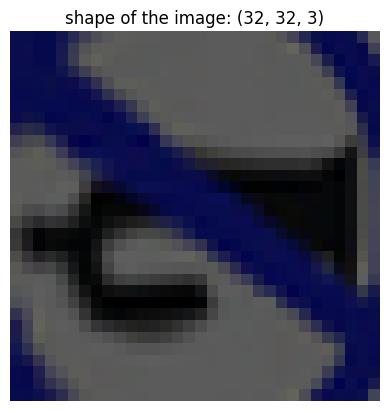

In [17]:
custom_image = cv2.imread(custom_image_path)

plt.imshow(img)
plt.title(f"shape of the image: {custom_image.shape}")
plt.axis(False)

Image tensor: 
tensor([[[0.3765, 0.3137, 0.1882,  ..., 0.3294, 0.6863, 0.8118],
         [0.3137, 0.3765, 0.1882,  ..., 0.3294, 0.1882, 0.7490],
         [0.3137, 0.3765, 0.1882,  ..., 0.3922, 0.1882, 0.5608],
         ...,
         [0.2039, 0.1098, 0.4824,  ..., 0.3059, 0.3608, 0.3608],
         [0.2510, 0.1882, 0.5020,  ..., 0.4078, 0.1882, 0.6235],
         [0.3137, 0.2510, 0.3765,  ..., 0.3137, 0.5020, 0.8118]]])

Shape of the transformed image: torch.Size([1, 32, 32])

Image tensor datatype: torch.float32


(-0.5, 31.5, 31.5, -0.5)

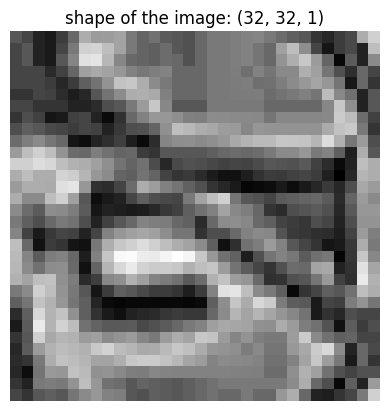

In [20]:
transformed_image = modified_test_data_transformation(custom_image)

print(f"Image tensor: \n{transformed_image}\n")
print(f"Shape of the transformed image: {transformed_image.shape}\n")
print(f"Image tensor datatype: {transformed_image.dtype}")

image_array = np.asarray(transformed_image.permute(1, 2, 0))

plt.imshow(image_array, cmap = 'gray')
plt.title(f"shape of the image: {image_array.shape}")
plt.axis(False)

Also we need to add one more extra dimension because our model expects the dimensions in the form of [batch_size, channel_number, height, width].

In [21]:
transformed_image = transformed_image.unsqueeze(dim=0)

print(f"Shape of the image tensor: {transformed_image.shape}")

Shape of the image tensor: torch.Size([1, 1, 32, 32])


In [70]:
model.eval()

with torch.inference_mode():
    transformed_image = transformed_image.to(device)
    
    y_logits = model(transformed_image)
    y_pred_prob = torch.softmax(y_logits, dim = 1)
    y_pred = torch.argmax(y_pred_prob, dim = 1).cpu().numpy()[0]
    
if y_pred_prob[0][y_pred].cpu().numpy() >= 0.9:
    predicted_sign = data[data['ClassId'] == y_pred]['Name'].values[0]
    print(f"Predicted Sign: {predicted_sign}")
else:
    print(f"Not getting the prediction having probability greater than threshold value.")

Predicted Sign: Horn prohibited


I want to make prediction on top of images of various classes but in an individual mode.

In [76]:
custom_image_list = [
    '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/2/2_original_45_original_45.png_193a8b9d-6ec5-4135-b462-0f19c9e96992.png_6d30ee27-5f8b-4643-9656-38c5cd4580a2.png',
    '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/3/3_original_46_original_46.png_18aee9fe-d2a4-4fad-b518-2ff5de632f8a.png_2048ef6f-ccaa-4986-b980-31cc68238283.png',
    '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/22/22_original_65_original_65.png_19f181e2-69ca-47b4-9e23-e7c96e94b529.png_79dbe233-349d-47b3-8f25-a8d528adf9df.png',
    '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/23/23_original_66_original_66.png_199aa142-171c-49ac-83b7-a271caa0e4e0.png_c699a876-ced5-49d8-9408-1da4d85404da.png',
    '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/24/24_original_67_original_67.png_0555c5e8-539a-44de-ba03-d7a9d50fc335.png_7232d55b-a304-4b35-bb90-316307c6827b.png',
    '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/36/36_original_79_original_79.png_1ca2966e-0760-4b25-b171-49631c51169f.png_05e56d52-3999-41f4-ad79-3305cfd649f0.png',
    '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/37/37_original_80_original_80.png_10fb4a3b-6872-4924-b71d-35b47c7a7aff.png_57a1c14b-34f8-47b0-b056-b7c0b1956b88.png',
    '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/42/42_original_85_original_85.png_1a6a4566-3c6b-4b38-9e22-8d65921b4fd4.png_2890c39a-9d44-4453-8285-fc2b0dbbfb89.png',
    '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/43/43_original_86_original_86.png_274beaef-2712-412f-b2fc-c68c11a503b8.png_13b21cef-716e-4146-9d58-92e4bd0e225a.png',
    '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/47/47_original_90_original_90.png_238640e2-f786-4fde-b06b-fb3d16cfe64d.png_1525c25e-b5f1-4838-b6a7-6f4187648f05.png',
    '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/48/48_original_91_original_91.png_2c28536c-3b29-4b32-ba76-50ceee0d41e1.png_cdbf8478-f192-49cd-8a6e-a6ba43081267.png',
    '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/49/92_original_92.png_72646a78-7d85-44d7-9514-fad79a44ffcc.png',
    '/kaggle/input/traffic-data/Indian-Traffic Sign-Dataset/Images/50/50_original_93_original_93.png_326de61b-e9de-42be-b711-57fa0de0d40e.png_3c1c55a4-1763-449a-b644-a34f8c458e48.png'
]

In [81]:
def make_prediction(image_list: List[str], model: nn.Module, transform: torchvision.transforms):
    
    for x in image_list:
        true_label = Path(x).parent.stem
        custom_image = cv2.imread(x)
        
        transformed_image = transform(custom_image)

        print("\n")
        print(f"Image tensor: \n{transformed_image}\n")
        print(f"Shape of the transformed image: {transformed_image.shape}\n")
        print(f"Image tensor datatype: {transformed_image.dtype}")
        
        transformed_image = transformed_image.unsqueeze(dim=0)
        
        print("\n")
        print(f"Shape of the image tensor: {transformed_image.shape}")
        
        model.eval()

        with torch.inference_mode():
            transformed_image = transformed_image.to(device)

            y_logits = model(transformed_image)
            y_pred_prob = torch.softmax(y_logits, dim = 1)
            y_pred = torch.argmax(y_pred_prob, dim = 1).cpu().numpy()[0]

        print(f"Actual Sign Label: {true_label}")
        
        if y_pred_prob[0][y_pred].cpu().numpy() >= 0.9:
            predicted_sign = data[data['ClassId'] == y_pred]['Name'].values[0]
            print(f"Predicted Sign: {predicted_sign}")
        else:
            print(f"Not getting the prediction having probability greater than threshold value.")
            
        print("="*20)

In [82]:
make_prediction(image_list = custom_image_list, model = model, transform = modified_test_data_transformation)



Image tensor: 
tensor([[[0.7490, 0.6863, 0.8118,  ..., 0.7490, 0.6235, 0.6863],
         [0.6235, 0.9373, 0.8745,  ..., 0.7961, 0.8745, 0.6863],
         [1.0000, 0.5608, 0.3765,  ..., 0.4706, 0.5608, 0.9373],
         ...,
         [0.7020, 0.1725, 0.2353,  ..., 0.2314, 0.1725, 0.5922],
         [0.8745, 0.8118, 0.5020,  ..., 0.5922, 0.7490, 0.8118],
         [1.0000, 0.9373, 0.6863,  ..., 0.7020, 0.8745, 1.0000]]])

Shape of the transformed image: torch.Size([1, 32, 32])

Image tensor datatype: torch.float32


Shape of the image tensor: torch.Size([1, 1, 32, 32])
Actual Sign Label: 2
Predicted Sign: One-way traffic


Image tensor: 
tensor([[[1.0000, 1.0000, 0.9373,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.8745,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.8745,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 0.9216,  ..., 0.9059, 0.9059, 0.9529],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000,

For majority of the classes we are getting the accurate predictions.

#### Yeah! So we're able to achieve our objective of this notebook.

Our objective is to get a CNN that can accurately classify the given traffic sign to its respective category.